In [1]:
# !pip install -U torch
# !pip install -U torchvision
# !pip install -U pillow==6.2.0
# !pip install -q monai
# !pip install -q git+https://github.com/ildoonet/pytorch-gradual-warmup-lr.git

In [2]:
from torch import nn
import numpy as np
import torch


CFG = {
    'image_target_cols': [
        'pe_present_on_image', # only image level
    ],
    'exam_target_cols': [
        'negative_exam_for_pe', # exam level
        'rv_lv_ratio_gte_1', # exam level
        'rv_lv_ratio_lt_1', # exam level
        'leftsided_pe', # exam level
        'chronic_pe', # exam level
        'rightsided_pe', # exam level
        'acute_and_chronic_pe', # exam level
        'central_pe', # exam level
        'indeterminate' # exam level
    ], 
    'image_weight': 0.07361963,
    'exam_weights': [0.0736196319, 0.2346625767, 0.0782208589, 0.06257668712, 0.1042944785, 0.06257668712, 0.1042944785, 0.1877300613, 0.09202453988],
}
def rsna_metric(label, predicted ,bce_func = torch.nn.BCELoss(reduction='none'),CFG=CFG):

    y_pred_exam = predicted
    y_true_exam = label
                
    total_loss = torch.tensor(0, dtype=torch.float32).cuda()
    total_weights = torch.tensor(0, dtype=torch.float32).cuda()
    
    label_w = torch.tensor(CFG['exam_weights']).view(1, -1).cuda()
    
    exam_loss = bce_func(y_pred_exam, y_true_exam)
    exam_loss = torch.sum(exam_loss*label_w, 1)[0] # Kaggle us
    
    total_loss += exam_loss
    total_weights += label_w.sum()
    final_loss = total_loss.cuda()/total_weights.cuda()
    return final_loss

class RsnaLoss(nn.Module):
    def __init__(self):
        super(RsnaLoss, self).__init__()
        self.rsna_metric = rsna_metric
    def forward(self,predicted,label):
        rsna = self.rsna_metric(label, predicted)
        return rsna

In [3]:
import monai

In [4]:
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '1,2,3' # specify GPUs locally

# libraries
import time
import numpy as np
import pandas as pd
import cv2
import PIL.Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm as tqdm
from sklearn.metrics import cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split, StratifiedKFold
import random

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data.sampler import SubsetRandomSampler, RandomSampler, SequentialSampler
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau, CosineAnnealingLR
from warmup_scheduler import GradualWarmupScheduler
from sklearn.metrics import roc_auc_score
import albumentations

import monai
from monai.data import NiftiDataset
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor

from apex import amp # I cannot install apex in Kagggle notebook

device = torch.device('cuda')

def set_seed(seed=0):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)  
    torch.cuda.manual_seed(seed)  
    torch.cuda.manual_seed_all(seed)  
#     torch.backends.cudnn.deterministic = True
    
set_seed(7777)

In [5]:
DEBUG = False

kernel_type = 'densenet121_pe'

image_size = 160
use_amp = False
data_dir = '../Datasets/RSNA/train256/train-jpegs'
num_workers = 32
init_lr = 1e-5
out_dim = 1
freeze_epo = 0
warmup_epo = 1
cosine_epo = 2 if DEBUG else 20
n_epochs = freeze_epo + warmup_epo + cosine_epo

In [6]:
target_cols = [
        'negative_exam_for_pe', # exam level
#         'rv_lv_ratio_gte_1', # exam level
#         'rv_lv_ratio_lt_1', # exam level
#         'leftsided_pe', # exam level
#         'chronic_pe', # exam level
#         'rightsided_pe', # exam level
#         'acute_and_chronic_pe', # exam level
#         'central_pe', # exam level
#         'indeterminate' # exam level
    ]

In [7]:
df = pd.read_csv('../Datasets/RSNA/train.csv')

In [8]:
# df = pd.read_csv('/media/medicalnfs/Datasets/RSNA/train.csv')
# df = df[(df.rv_lv_ratio_gte_1 == 1) | ( df.rv_lv_ratio_lt_1==1)].reset_index(drop=True)
# df.head()

In [9]:
from sklearn.model_selection import GroupKFold

np.random.seed(0)
group_kfold = GroupKFold(n_splits=5)
print(group_kfold)

df['fold'] = -1
for i, (_, val_index) in enumerate(group_kfold.split(df, groups=df.StudyInstanceUID)):
    df.loc[val_index, 'fold'] = i

df.fold.value_counts()

GroupKFold(n_splits=5)


2    358142
4    358138
1    358127
0    358125
3    358062
Name: fold, dtype: int64

In [10]:
df_study = df.drop_duplicates('StudyInstanceUID')[['StudyInstanceUID','SeriesInstanceUID','fold']+target_cols]
if DEBUG:
    df_study = df_study.head(1000)

In [11]:
def preper(row):
    jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
    img_lst = [cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst] 
    img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)
    return row.StudyInstanceUID,img

In [12]:
# all_imgs ={}
# for index,row in tqdm(df_study.iterrows()):
#     jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
#     img_lst = [cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst] 
#     img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)
#     all_imgs[row.StudyInstanceUID] = img

In [13]:
from joblib import Parallel, delayed
from glob import glob
from monai.transforms import LoadNifti, Randomizable, apply_transform
from monai.transforms import AddChannel, Compose, RandRotate90, Resize, ScaleIntensity, ToTensor, RandAffine
from monai.utils import get_seed
from tqdm.auto import tqdm
# x = Parallel(n_jobs=32)(delayed(preper)(row) for index,row in tqdm(df_study.iterrows()))

In [14]:
# all_imgs ={}

In [15]:
# for row in x:
#     all_imgs[row[0]] = row[1]

In [16]:
class RSNADataset3D(torch.utils.data.Dataset, Randomizable):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self._seed = self.R.randint(MAX_SEED, dtype="uint32")    

    def __getitem__(self, index):
        self.randomize()
        row = self.csv.iloc[index]
        jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
        img_lst = np.array([cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst])
#         print(img_lst.shape)
#         if np.random.randint(2)==0 and self.mode=='train':
#             img_lst = img_lst[::-1]
        if np.random.randint(2)==0 and self.mode=='train':
            z = np.random.randint(1,max(len(img_lst)//6,10))
            y = np.random.randint(3,30)
            x = np.random.randint(3,30)
            img_lst = img_lst[z:-z,x:-x,y:-y]
#             print("flip")
        img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)
        
        if self.transform is not None:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self._seed)
            img = apply_transform(self.transform, img)
            
        if self.mode == 'test':
            return img
        else:
            return img, torch.tensor(row[target_cols]).float()

In [17]:
def default_collate(batch):
    data = torch.stack([item[0] for item in batch])
    target = torch.stack([item[1] for item in batch])  # image labels.
    return data, target

In [18]:
train_transforms = Compose([ScaleIntensity(), 
                            Resize((image_size, image_size, image_size)), 
                            RandAffine( 
                                      prob=0.5,
#                                       rotate_range=(np.pi * 2, np.pi * 2, np.pi * 2),
                                      scale_range=(0.15, 0.15, 0.15),
                                      padding_mode='border'),
                            ToTensor()])
val_transforms = Compose([ScaleIntensity(),Resize((image_size, image_size, image_size)),ToTensor()])

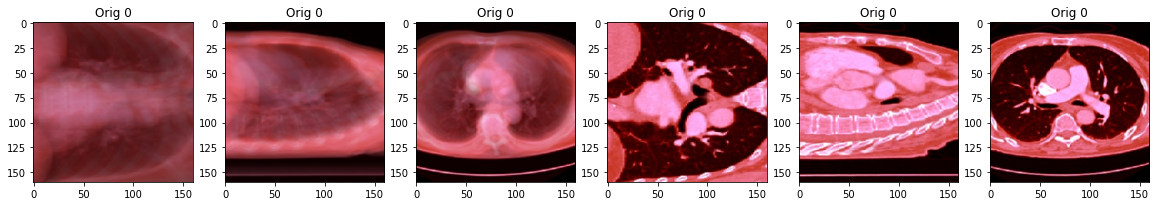

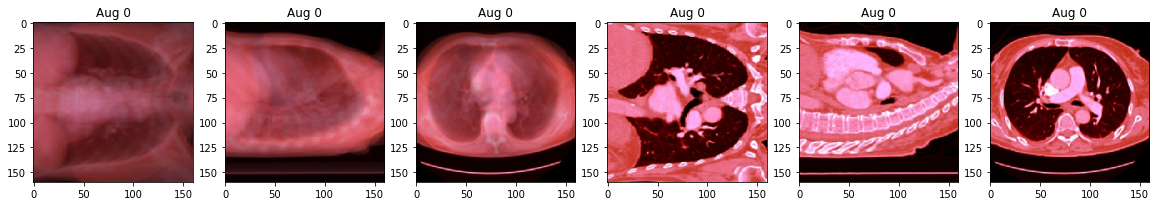

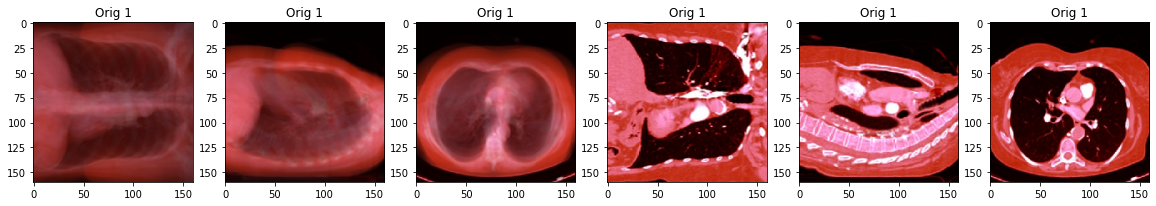

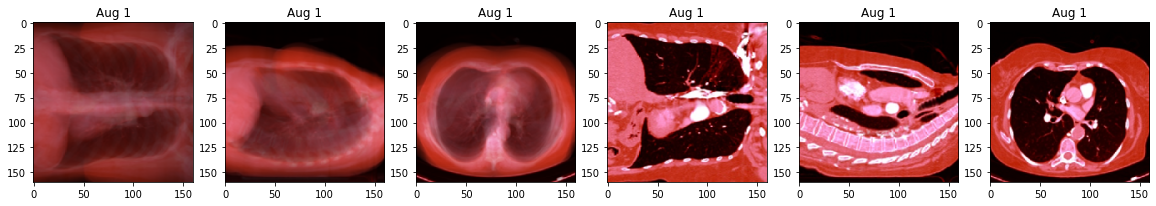

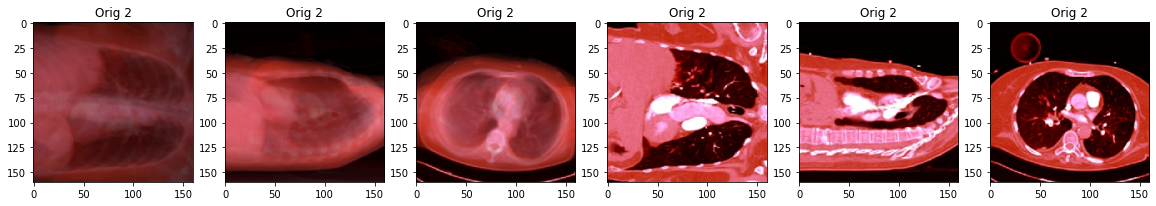

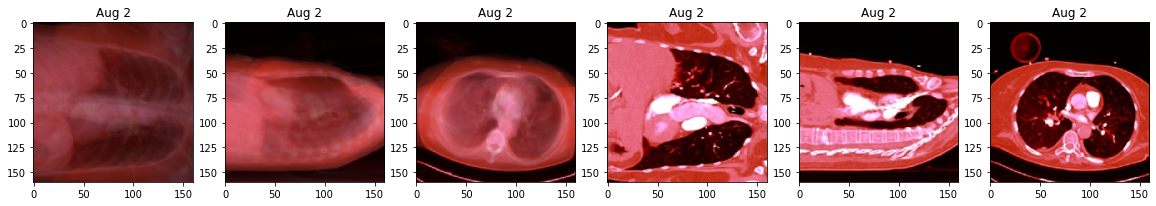

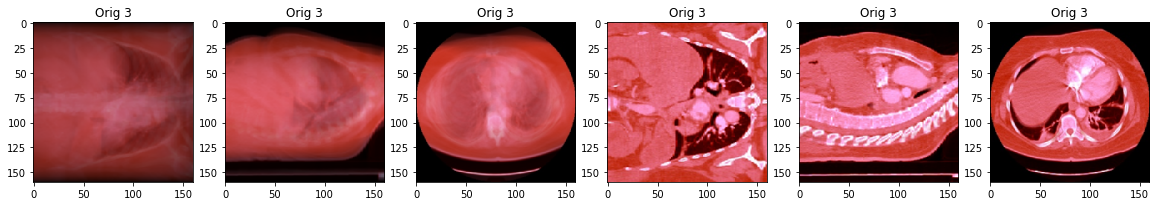

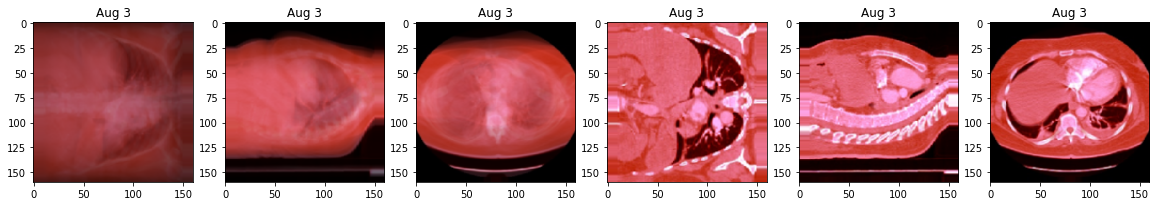

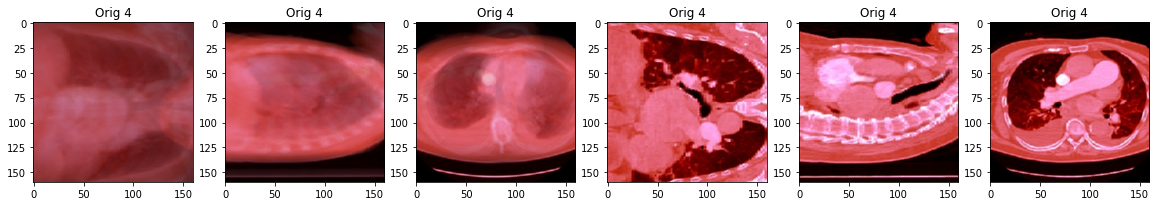

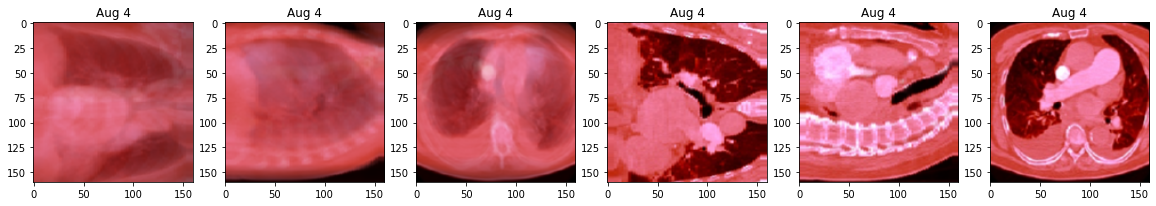

In [19]:
dataset_show = RSNADataset3D(df_study.head(5), 'train', transform=val_transforms)
dataset_show_aug = RSNADataset3D(df_study.head(5), 'train', transform=train_transforms)
from pylab import rcParams
rcParams['figure.figsize'] = 20,5
for i in range(5):
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show[i]
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Orig {i}")
    f, axarr = plt.subplots(1,6)
    img, label = dataset_show_aug[i]  
    img = torch.nn.functional.interpolate(img.unsqueeze(0), size=(160,160,160))[0]
    for j in range(6):        
        if j<=2: axarr[j].imshow(img.numpy().transpose(1,2,3,0).mean(axis=j))
        elif j==3: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[image_size//2,:,:])
        elif j==4: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,image_size//2,:])
        elif j==5: axarr[j].imshow(img.numpy().transpose(1,2,3,0)[:,:,image_size//2])
        axarr[j].set_title(f"Aug {i}")
    plt.show()

In [20]:
# bce = nn.BCEWithLogitsLoss(weight= torch.tensor(CFG['exam_weights']).view(-1).cuda())
bce = nn.BCEWithLogitsLoss()
def criterion(logits, target): 
    loss = bce(logits.cuda(), target.cuda())
    return loss

In [21]:
def train_epoch(model, loader, optimizer):

    model.train()
    train_loss = []
    bar = tqdm(loader)
    for (data, target) in bar:
        data, target = data.to(device), target.to(device)
#         data = torch.nn.functional.interpolate(data, size=(160,160,160))
        optimizer.zero_grad()
        logits = model(data)       
        loss = criterion(logits, target)

        if not use_amp:
            loss.backward()
        else:
            with amp.scale_loss(loss, optimizer) as scaled_loss:
                scaled_loss.backward()

        optimizer.step()

        loss_np = loss.detach().cpu().numpy()
        train_loss.append(loss_np)
        smooth_loss = sum(train_loss[-100:]) / min(len(train_loss), 100)
        bar.set_description('loss: %.5f, smth: %.5f' % (loss_np, smooth_loss))
    return train_loss


def val_epoch(model, loader, is_ext=None, n_test=1, get_output=False):

    model.eval()
    val_loss = []
    LOGITS = []
    TARGETS = []

    with torch.no_grad():
        for (data, target) in tqdm(loader):
            data, target = data.to(device), target.to(device)
#             data = torch.nn.functional.interpolate(data, size=(160,160,160))
            logits = model(data)
            LOGITS.append(logits.detach().cpu())
            TARGETS.append(target.detach().cpu())

    val_loss = criterion(torch.cat(LOGITS), torch.cat(TARGETS)).cpu().numpy()
    PROBS = torch.sigmoid(torch.cat(LOGITS)).cpu().numpy().squeeze()    
    LOGITS = torch.cat(LOGITS).cpu().numpy()
    TARGETS = torch.cat(TARGETS).cpu().numpy()
    
    if get_output:
        return LOGITS, PROBS, TARGETS
    else:
        acc = (PROBS.round() == TARGETS).mean() * 100.
        auc = roc_auc_score(TARGETS, LOGITS)
        return float(val_loss), acc, auc

In [22]:
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)
    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in self.base_lrs]

In [23]:
# monai.networks.nets.senet.se_resnext50_32x4d?

In [24]:
def run(fold):
    df_train = df_study[(df_study['fold'] != fold)]
    df_valid = df_study[(df_study['fold'] == fold)]

    dataset_train = RSNADataset3D(df_train, 'train', transform=train_transforms)
    dataset_valid = RSNADataset3D(df_valid, 'val', transform=val_transforms)
    train_loader = torch.utils.data.DataLoader(dataset_train, batch_size=9, sampler=RandomSampler(dataset_train), num_workers=num_workers)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=9, num_workers=num_workers)

#     model = monai.networks.nets.senet.se_resnext101_32x4d(spatial_dims=3, in_channels=3, num_classes=out_dim).to(device)
    model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=out_dim).to(device)

    val_loss_best = 1000
    model_file = f'{kernel_type}_best_fold{fold}.pth'

    optimizer = optim.AdamW(model.parameters(), lr=init_lr)
    if use_amp:
        model, optimizer = amp.initialize(model, optimizer, opt_level="O1")
#     if len(os.environ['CUDA_VISIBLE_DEVICES'].split(',')) > 1:
    model = nn.DataParallel(model) 
#     if os.path.exists(model_file):
#         model.load_state_dict(torch.load(model_file))
#         print("load")
#     if fold==1:
#         model.load_state_dict(torch.load('densenet121_best_fold1.pth'))
#         print("load")
    scheduler_cosine = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, cosine_epo)
    scheduler_warmup = GradualWarmupSchedulerV2(optimizer, multiplier=10, total_epoch=warmup_epo, after_scheduler=scheduler_cosine)

    print(len(dataset_train), len(dataset_valid))

    for epoch in range(1, n_epochs+1):
        print(time.ctime(), 'Epoch:', epoch)
        scheduler_warmup.step(epoch-1)

        train_loss = train_epoch(model, train_loader, optimizer)
        val_loss, acc, auc = val_epoch(model, valid_loader)
    
        content = time.ctime() + ' ' + f'Fold {fold}, Epoch {epoch}, lr: {optimizer.param_groups[0]["lr"]:.7f}, train loss: {np.mean(train_loss):.5f}, valid loss: {(val_loss):.5f}, acc: {(acc):.4f}, auc: {(auc):.6f}'
        print(content)
        with open(f'log_{kernel_type}.txt', 'a') as appender:
            appender.write(content + '\n')             
            
        if val_loss < val_loss_best:
            print('val_loss_best ({:.6f} --> {:.6f}).  Saving model ...'.format(val_loss_best, val_loss))
            torch.save(model.state_dict(), model_file)
            val_loss_best = val_loss

    torch.save(model.state_dict(), f'{kernel_type}_model_fold{fold}.pth')

In [ ]:
run(fold=1)

5823 1456
Thu Oct 22 06:08:49 2020 Epoch: 1


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:123: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://git


Thu Oct 22 06:40:35 2020 Fold 1, Epoch 1, lr: 0.0000100, train loss: 0.63344, valid loss: 0.63445, acc: 66.3462, auc: 0.583428
val_loss_best (1000.000000 --> 0.634451).  Saving model ...
Thu Oct 22 06:40:35 2020 Epoch: 2


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)



Thu Oct 22 07:11:54 2020 Fold 1, Epoch 2, lr: 0.0001000, train loss: 0.62987, valid loss: 0.63076, acc: 66.3237, auc: 0.601574
val_loss_best (0.634451 --> 0.630759).  Saving model ...
Thu Oct 22 07:11:55 2020 Epoch: 3


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:143: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:942: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  "please use `get_last_lr()`.", UserWarning)



Thu Oct 22 07:41:41 2020 Fold 1, Epoch 3, lr: 0.0001000, train loss: 0.62286, valid loss: 0.63712, acc: 66.3462, auc: 0.530623
Thu Oct 22 07:41:41 2020 Epoch: 4



Thu Oct 22 08:10:54 2020 Fold 1, Epoch 4, lr: 0.0000976, train loss: 0.63013, valid loss: 0.63888, acc: 66.2788, auc: 0.550758
Thu Oct 22 08:10:54 2020 Epoch: 5



Thu Oct 22 08:41:23 2020 Fold 1, Epoch 5, lr: 0.0000946, train loss: 0.62859, valid loss: 0.63887, acc: 66.3462, auc: 0.575288
Thu Oct 22 08:41:23 2020 Epoch: 6



Thu Oct 22 09:12:22 2020 Fold 1, Epoch 6, lr: 0.0000905, train loss: 0.62640, valid loss: 0.63531, acc: 66.3462, auc: 0.619804
Thu Oct 22 09:12:22 2020 Epoch: 7



Thu Oct 22 09:42:58 2020 Fold 1, Epoch 7, lr: 0.0000854, train loss: 0.62207, valid loss: 0.63577, acc: 66.2788, auc: 0.563886
Thu Oct 22 09:42:58 2020 Epoch: 8



Thu Oct 22 10:14:08 2020 Fold 1, Epoch 8, lr: 0.0000794, train loss: 0.62105, valid loss: 0.60853, acc: 65.3357, auc: 0.660717
val_loss_best (0.630759 --> 0.608533).  Saving model ...
Thu Oct 22 10:14:08 2020 Epoch: 9



Thu Oct 22 10:44:53 2020 Fold 1, Epoch 9, lr: 0.0000727, train loss: 0.61146, valid loss: 0.58626, acc: 61.7207, auc: 0.696681
val_loss_best (0.608533 --> 0.586261).  Saving model ...
Thu Oct 22 10:44:54 2020 Epoch: 10



Thu Oct 22 11:16:00 2020 Fold 1, Epoch 10, lr: 0.0000655, train loss: 0.60082, valid loss: 0.59235, acc: 64.0110, auc: 0.689547
Thu Oct 22 11:16:00 2020 Epoch: 11



Thu Oct 22 11:46:28 2020 Fold 1, Epoch 11, lr: 0.0000578, train loss: 0.59513, valid loss: 0.57945, acc: 63.4721, auc: 0.709281
val_loss_best (0.586261 --> 0.579446).  Saving model ...
Thu Oct 22 11:46:28 2020 Epoch: 12



Thu Oct 22 12:15:17 2020 Fold 1, Epoch 12, lr: 0.0000500, train loss: 0.58272, valid loss: 0.57260, acc: 62.4617, auc: 0.715672
val_loss_best (0.579446 --> 0.572601).  Saving model ...
Thu Oct 22 12:15:18 2020 Epoch: 13



Thu Oct 22 12:44:25 2020 Fold 1, Epoch 13, lr: 0.0000422, train loss: 0.57662, valid loss: 0.56844, acc: 62.0800, auc: 0.726457
val_loss_best (0.572601 --> 0.568443).  Saving model ...
Thu Oct 22 12:44:26 2020 Epoch: 14



Thu Oct 22 13:16:26 2020 Fold 1, Epoch 14, lr: 0.0000345, train loss: 0.56858, valid loss: 0.56478, acc: 61.6085, auc: 0.726053
val_loss_best (0.568443 --> 0.564779).  Saving model ...
Thu Oct 22 13:16:26 2020 Epoch: 15


In [ ]:
run(fold=2)

In [ ]:
run(fold=0)

In [ ]:
run(fold=3)

In [ ]:
run(fold=4)

In [25]:
from sklearn.metrics import confusion_matrix

In [26]:
if not os.path.exists(f"features_{kernel_type}"):
    os.makedirs(f"features_{kernel_type}")

In [28]:
class RSNADataset3D(torch.utils.data.Dataset, Randomizable):
    def __init__(self, csv, mode, transform=None):

        self.csv = csv.reset_index()
        self.mode = mode
        self.transform = transform

    def __len__(self):
        return self.csv.shape[0]
    
    def randomize(self) -> None:
        MAX_SEED = np.iinfo(np.uint32).max + 1
        self._seed = self.R.randint(MAX_SEED, dtype="uint32")    

    def __getitem__(self, index):
        self.randomize()
        row = self.csv.iloc[index]
        jpg_lst = sorted(glob(os.path.join(data_dir, row.StudyInstanceUID, row.SeriesInstanceUID, '*.jpg')))
        img_lst = [cv2.imread(jpg)[:,:,::-1] for jpg in jpg_lst] 
        img = np.stack([image.astype(np.float32) for image in img_lst], axis=2).transpose(3,0,1,2)
        
        if self.transform is not None:
            if isinstance(self.transform, Randomizable):
                self.transform.set_random_state(seed=self._seed)
            img = apply_transform(self.transform, img)
            
        if self.mode == 'test':
            return img
        else:
            return img, torch.tensor(row[target_cols]).float(),row.StudyInstanceUID

In [30]:
torch.multiprocessing.set_sharing_strategy('file_system')
for fold in range(0,5):
    df_valid = df_study[(df_study['fold'] == fold)]
    dataset_valid = RSNADataset3D(df_valid, 'val', transform=val_transforms)
    valid_loader = torch.utils.data.DataLoader(dataset_valid, batch_size=1, num_workers=num_workers)
    def load_model(model_file):
        model = monai.networks.nets.densenet.densenet121(spatial_dims=3, in_channels=3, out_channels=out_dim).to(device)
        try:  # single GPU model_file
            model.load_state_dict(torch.load(model_file), strict=True)
        except:  # multi GPU model_file
            state_dict = torch.load(model_file)
            state_dict = {k[7:] if k.startswith('module.') else k: state_dict[k] for k in state_dict.keys()}
            model.load_state_dict(state_dict, strict=True)

        model.eval()    
        print()
        return model

    LOGITS = []
    PROBS = []
    try:
        model = load_model(f'{kernel_type}_best_fold{fold}.pth')
    except:
        model = load_model(f'{kernel_type}_model_fold{fold}.pth')
    model.eval()
    with torch.no_grad():
        for data,target,name in tqdm(valid_loader):
            data = data.to(device)
            target = target.numpy().reshape(-1)
            l1 = model(data)
            l = torch.sigmoid(l1)
            LOGITS.append(l.detach().cpu().numpy().reshape(-1))
            PROBS.append(target) 
            l2 = model.features(data).cpu().numpy()[0]
            np.save(f"features_{kernel_type}/{name[0]}_3dcnn.npy",l2)
            np.save(f"features_{kernel_type}/{name[0]}_3dprob.npy",l1.cpu().numpy().reshape(-1))
    print(fold)
    print(confusion_matrix(np.array(PROBS)>0.5,np.array(LOGITS)>0.5))


0
[[140 330]
 [ 90 896]]




1
[[200 290]
 [118 848]]




2
[[181 297]
 [ 89 889]]




3
[[132 325]
 [ 50 948]]




4
[[189 284]
 [ 94 889]]
